In [7]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import CnnPolicy
from stable_baselines3.ppo.policies import MlpPolicy
from utils.adversary_env import AdversaryEnv
from utils.cartpole_wrapper import CartPoleWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Load target model
target_model = PPO.load("../ppo/models/cartpole-v1/cartpole_v1_ppo_510K")

In [8]:
# Test target model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(target_model, Monitor(CartPoleWrapper(gym.make('CartPole-v1'))), n_eval_episodes=50)
print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 0.37 +/- 0.03


In [9]:
# Create adversary with adversary env
# adversary_env = AdversaryEnv(CartPoleWrapper(gym.make('CartPole-v1')), target_model)
# adversary = PPO(MlpPolicy, adversary_env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Train adversary
# log_dir = "./out/training-log/"
# log_path = log_dir + f"adversary-adversary-cartpole-v1/"
# save_dir = "./models/adversary-cartpole-v1/"

# timesteps = 50000

# adversary.learn(
#         total_timesteps=timesteps,
#         callback=None,
#         log_interval=-1,
#         eval_env=adversary_env, 
#         eval_freq=5000, 
#         n_eval_episodes=100,
#         tb_log_name='PPO',
#         eval_log_path=log_path, 
#         reset_num_timesteps=False
#         )

# # Save adversary
# adversary.save(save_dir + f"adversary_cartpole_v1_{timesteps}")

In [5]:
# Load adversary
save_dir = "./models/adversary-cartpole-v1/"

adversary = PPO.load(save_dir + f"adversary_cartpole_v1_50000")
adversary_env = AdversaryEnv(CartPoleWrapper(gym.make('CartPole-v1')), target_model)

In [11]:
import numpy as np
import pandas as pd
from uniform_attack import UniformAttack

# Evaluate uniform adversarial attack over different epsilon
data_dict = {
    'epsilon': [],
    'mean_rew': [],
    'mean_perturbation': [],
    'mean_n_timesteps': [],
    'mean_n_attacks': []
}

n_episodes = 50

for j in range(1, 50):
    epsilon = j/100

    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_n_timesteps = []
    all_episodes_n_attacks = []

    for i in range(0, n_episodes):
        # Run attack on a2c model
        env = CartPoleWrapper(gym.make('CartPole-v1'))
        ua = UniformAttack(env=env, model=target_model, attack=adversary, epsilon=epsilon)
        ua.perform_attack()

        all_episodes_rewards.append(ua.reward_total)
        all_episodes_perturbation.append(ua.perturbation_total)
        all_episodes_n_timesteps.append(ua.frames_count)
        all_episodes_n_attacks.append(ua.n_attacks)

        ua.reset_attack()

    data_dict['epsilon'].append(epsilon)
    data_dict['mean_rew'].append(np.round(np.mean(all_episodes_rewards), 2))
    data_dict['mean_perturbation'].append(np.round(np.mean(all_episodes_perturbation), 2))
    data_dict['mean_n_timesteps'].append(np.round(np.mean(all_episodes_n_timesteps), 2))
    data_dict['mean_n_attacks'].append(np.round(np.mean(all_episodes_n_attacks), 2))

    print("------------------------------------------")
    print(
        f"{data_dict['epsilon'][-1] = }: \n" +
        f"{data_dict['mean_rew'][-1] = } \n" +
        f"{data_dict['mean_perturbation'][-1] = } \n" +
        f"{data_dict['mean_n_timesteps'][-1] = } \n" +
        f"{data_dict['mean_n_attacks'][-1] = }"
        )
    print("------------------------------------------")

------------------------------------------
data_dict['epsilon'][-1] = 0.01: 
data_dict['mean_rew'][-1] = 0.54 
data_dict['mean_perturbation'][-1] = 13.88 
data_dict['mean_n_timesteps'][-1] = 500.0 
data_dict['mean_n_attacks'][-1] = 500.0
------------------------------------------
------------------------------------------
data_dict['epsilon'][-1] = 0.02: 
data_dict['mean_rew'][-1] = 0.59 
data_dict['mean_perturbation'][-1] = 28.03 
data_dict['mean_n_timesteps'][-1] = 500.0 
data_dict['mean_n_attacks'][-1] = 500.0
------------------------------------------
------------------------------------------
data_dict['epsilon'][-1] = 0.03: 
data_dict['mean_rew'][-1] = 0.68 
data_dict['mean_perturbation'][-1] = 42.54 
data_dict['mean_n_timesteps'][-1] = 500.0 
data_dict['mean_n_attacks'][-1] = 500.0
------------------------------------------
------------------------------------------
data_dict['epsilon'][-1] = 0.04: 
data_dict['mean_rew'][-1] = 0.77 
data_dict['mean_perturbation'][-1] = 57.41 
da

In [12]:
print(data_dict)

{'epsilon': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49], 'mean_rew': [0.54, 0.59, 0.68, 0.77, 0.88, 1.04, 1.24, 1.32, 1.7, 1.79, 1.72, 0.64, -0.22, -1.08, -1.28, -1.43, -1.6, -1.65, -1.71, -1.74, -1.87, -1.86, -1.91, -1.96, -2.0, -2.06, -2.09, -2.09, -2.13, -2.2, -2.14, -2.2, -2.27, -2.31, -2.33, -2.29, -2.34, -2.33, -2.47, -2.44, -2.54, -2.49, -2.5, -2.58, -2.56, -2.61, -2.65, -2.62, -2.57], 'mean_perturbation': [13.88, 28.03, 42.54, 57.41, 72.62, 88.72, 105.71, 120.4, 140.91, 154.79, 159.03, 130.71, 98.43, 54.33, 44.17, 35.77, 25.86, 23.47, 24.54, 22.85, 19.12, 18.0, 16.4, 15.88, 14.83, 16.37, 14.79, 15.66, 14.21, 15.45, 15.01, 15.38, 16.36, 15.48, 15.67, 16.21, 16.84, 16.79, 17.24, 16.96, 17.94, 18.19, 17.93, 18.7, 19.43, 19.67, 19.42, 19.9

In [13]:
# Create DataFrame
labels = ['epsilon', 'mean_rew', 'mean_perturbation', 'mean_n_timsteps', 'mean_n_attacks']

data_df = pd.DataFrame(
        data_dict, 
        columns=labels,
        )
data_df.set_index('epsilon', inplace=True)

# Save data as .csv file
with open("./out/data/" + "uniform_attack_epsilon", 'w') as f:
    data_df.to_csv(f)

data_df

,mean_rew,mean_perturbation,mean_n_timsteps,mean_n_attacks
epsilon,,,,
0.01,0.54,13.88,NaN,500.00
0.02,0.59,28.03,NaN,500.00
0.03,0.68,42.54,NaN,500.00
0.04,0.77,57.41,NaN,500.00
0.05,0.88,72.62,NaN,500.00
0.06,1.04,88.72,NaN,500.00
0.07,1.24,105.71,NaN,500.00
0.08,1.32,120.40,NaN,487.30
0.09,1.70,140.91,NaN,500.00


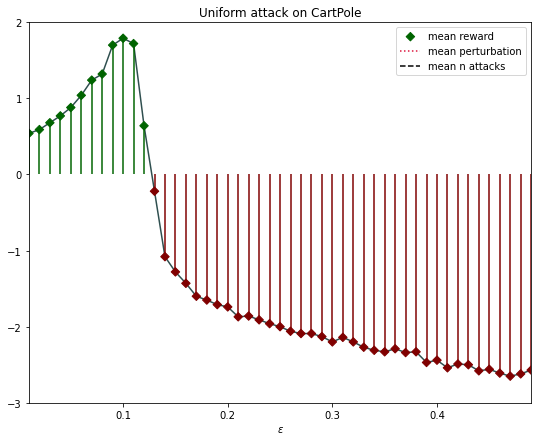

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load data
with open("./out/data/" + "uniform_attack_epsilon", 'r') as f:
    data_df = pd.read_csv(f, index_col=0)

# Plot data_df
plt.figure(figsize=(9,7))
plt.plot(data_df.index, data_df['mean_rew'], color='darkslategray', alpha=1, zorder=0)
plt.vlines(data_df.index, ymin=0, ymax=data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
plt.scatter(data_df.index, data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

plt.plot(data_df.index, data_df['mean_perturbation'], label='mean perturbation', color='crimson', linestyle='dotted', alpha=1, zorder=0)

# plt.plot(data_df.index, data_df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dotted', alpha=1, zorder=0)

plt.plot(data_df.index, data_df['mean_n_attacks'], label='mean n attacks', color='black', linestyle='dashed', alpha=1, zorder=0)

plt.title("Uniform attack on CartPole")
plt.legend()
plt.xlabel('$\epsilon$')
# plt.ylabel()
plt.axis([0.01, 0.49, -3, 2]) # plt.axis([xmin, xmax, ymin, ymax])
plt.show()